<h2> Import the required libraries </h2><br>
    Softwares: Python 3.7<br>
    Libraries: Numpy, Pandas, Matplotlib, Seaborn, SKlearn, Statsmodel, OS<br>
    ML Libraries Used: XGBoost, Decision Trees, Random Forest, Keras Neural Networks, LightGBM

In [480]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from glob import glob
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from scipy.signal import butter, lfilter, filtfilt
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import confusion_matrix as c_m
from sklearn.metrics import classification_report as clfrep
from sklearn.metrics import r2_score as r2score
from sklearn.metrics import roc_auc_score as roc_auc
import os
cwd = os.getcwd()
os.chdir('C:/Users/Shashi Suman/Desktop/AI Project/A_DeviceMotion_data/A_DeviceMotion_data')
Folders = glob('./*_*')
Folders = [s for s in Folders if "csv" not in s]

<h2> Gather All Data </h2><br>
Apply a Low Pass filter of each activity and merge the dataset for every activity <br>
Low Pass Filter used: Moving Average

Run a window accross dataset and compute its features<br>
Window Length: 150<br>
Features: Mean, Skew, Kurtosis, Standard Deviation<br>

Sample the data @ 30Hz


In [556]:
Big_fat_Df = []
window = 150
sampling_rate = 30
Activity_Types = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6} 
codes = {1:'dws',2:'jog', 3:'sit', 4:'std', 5:'ups', 6:'wlk'}
for j in Folders:
    Csv = glob(j + '/sub_*.csv' )
    for i in Csv:
        df = pd.read_csv(i)
        df.drop('Unnamed: 0', 1, inplace=True)
        cols = [i for i in df.columns]
        for i in df.columns:
            df[str(i)+'_mean'] = df[[str(i)]].rolling(window).mean()
            #df[str(i)+'_median'] = df[[str(i)]].rolling(window).median()
            #df[str(i)+'_butter'] = pd.DataFrame(signal.filtfilt(b, a, df[str(i)]))
            df[str(i)+'_std'] = df[[str(i)]].rolling(window).std()
            df[str(i)+'_skew'] = df[[str(i)]].rolling(window).skew()
            df[str(i)+'_kurt'] = df[[str(i)]].rolling(window).kurt()
        df['Activity'] = Activity_Types[j[2:5]]
        df.drop(cols, axis=1, inplace=True)
        df = df.dropna().reset_index(drop=True)
        Big_fat_Df.append(df[::sampling_rate])
df = pd.concat(Big_fat_Df, axis = 0)

cols = [i for i in df.columns]
X, Y = df[cols[:len(cols)-1]], df['Activity']
train_cols = [i for i in X.columns]
from sklearn.model_selection import train_test_split as tts
train_X, test_X, train_y, test_y = tts(X, Y, test_size=0.3, random_state = 42)

<h1> Activity Analysis w.r.t Standard Deviation </h1>

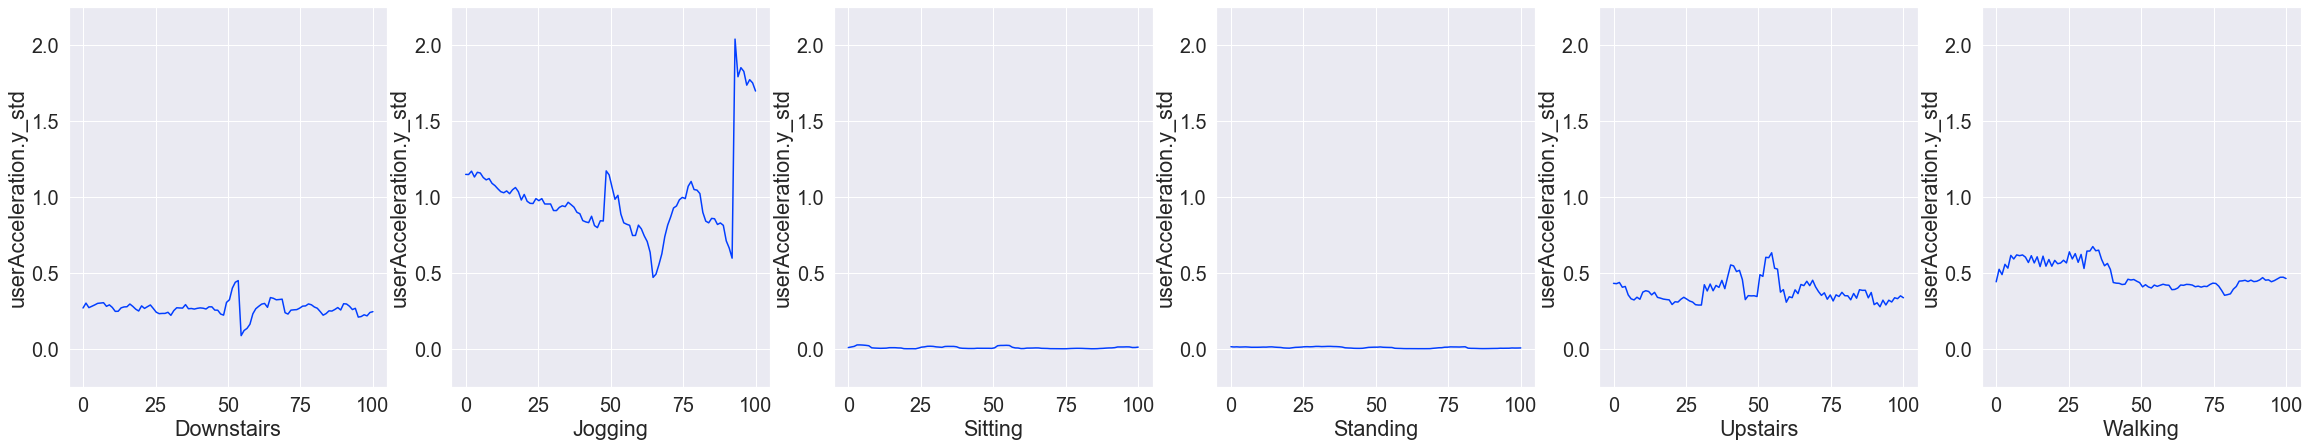

In [672]:
cf = df.groupby(['Activity']).head(100)
codes = {1:'Downstairs',2:'Jogging', 3:'Sitting', 4:'Standing', 5:'Upstairs', 6:'Walking'}
sns.set(palette='bright', font_scale=1.8)
fig, ax = plt.subplots(nrows=1, ncols=6)
fig.set_size_inches(40,7)
for i in range(6):
    sns.lineplot(x=np.linspace(0,100,100), y=cf[cf['Activity']==i+1]['userAcceleration.y_std'], ax=ax[i])
    ax[i].set(xlabel=codes[i+1])
    ax[i].set_ylim(-0.25, 2.25)

<h1> Butterworth Filter with various cut-off frequencies on Each Activity </h1>

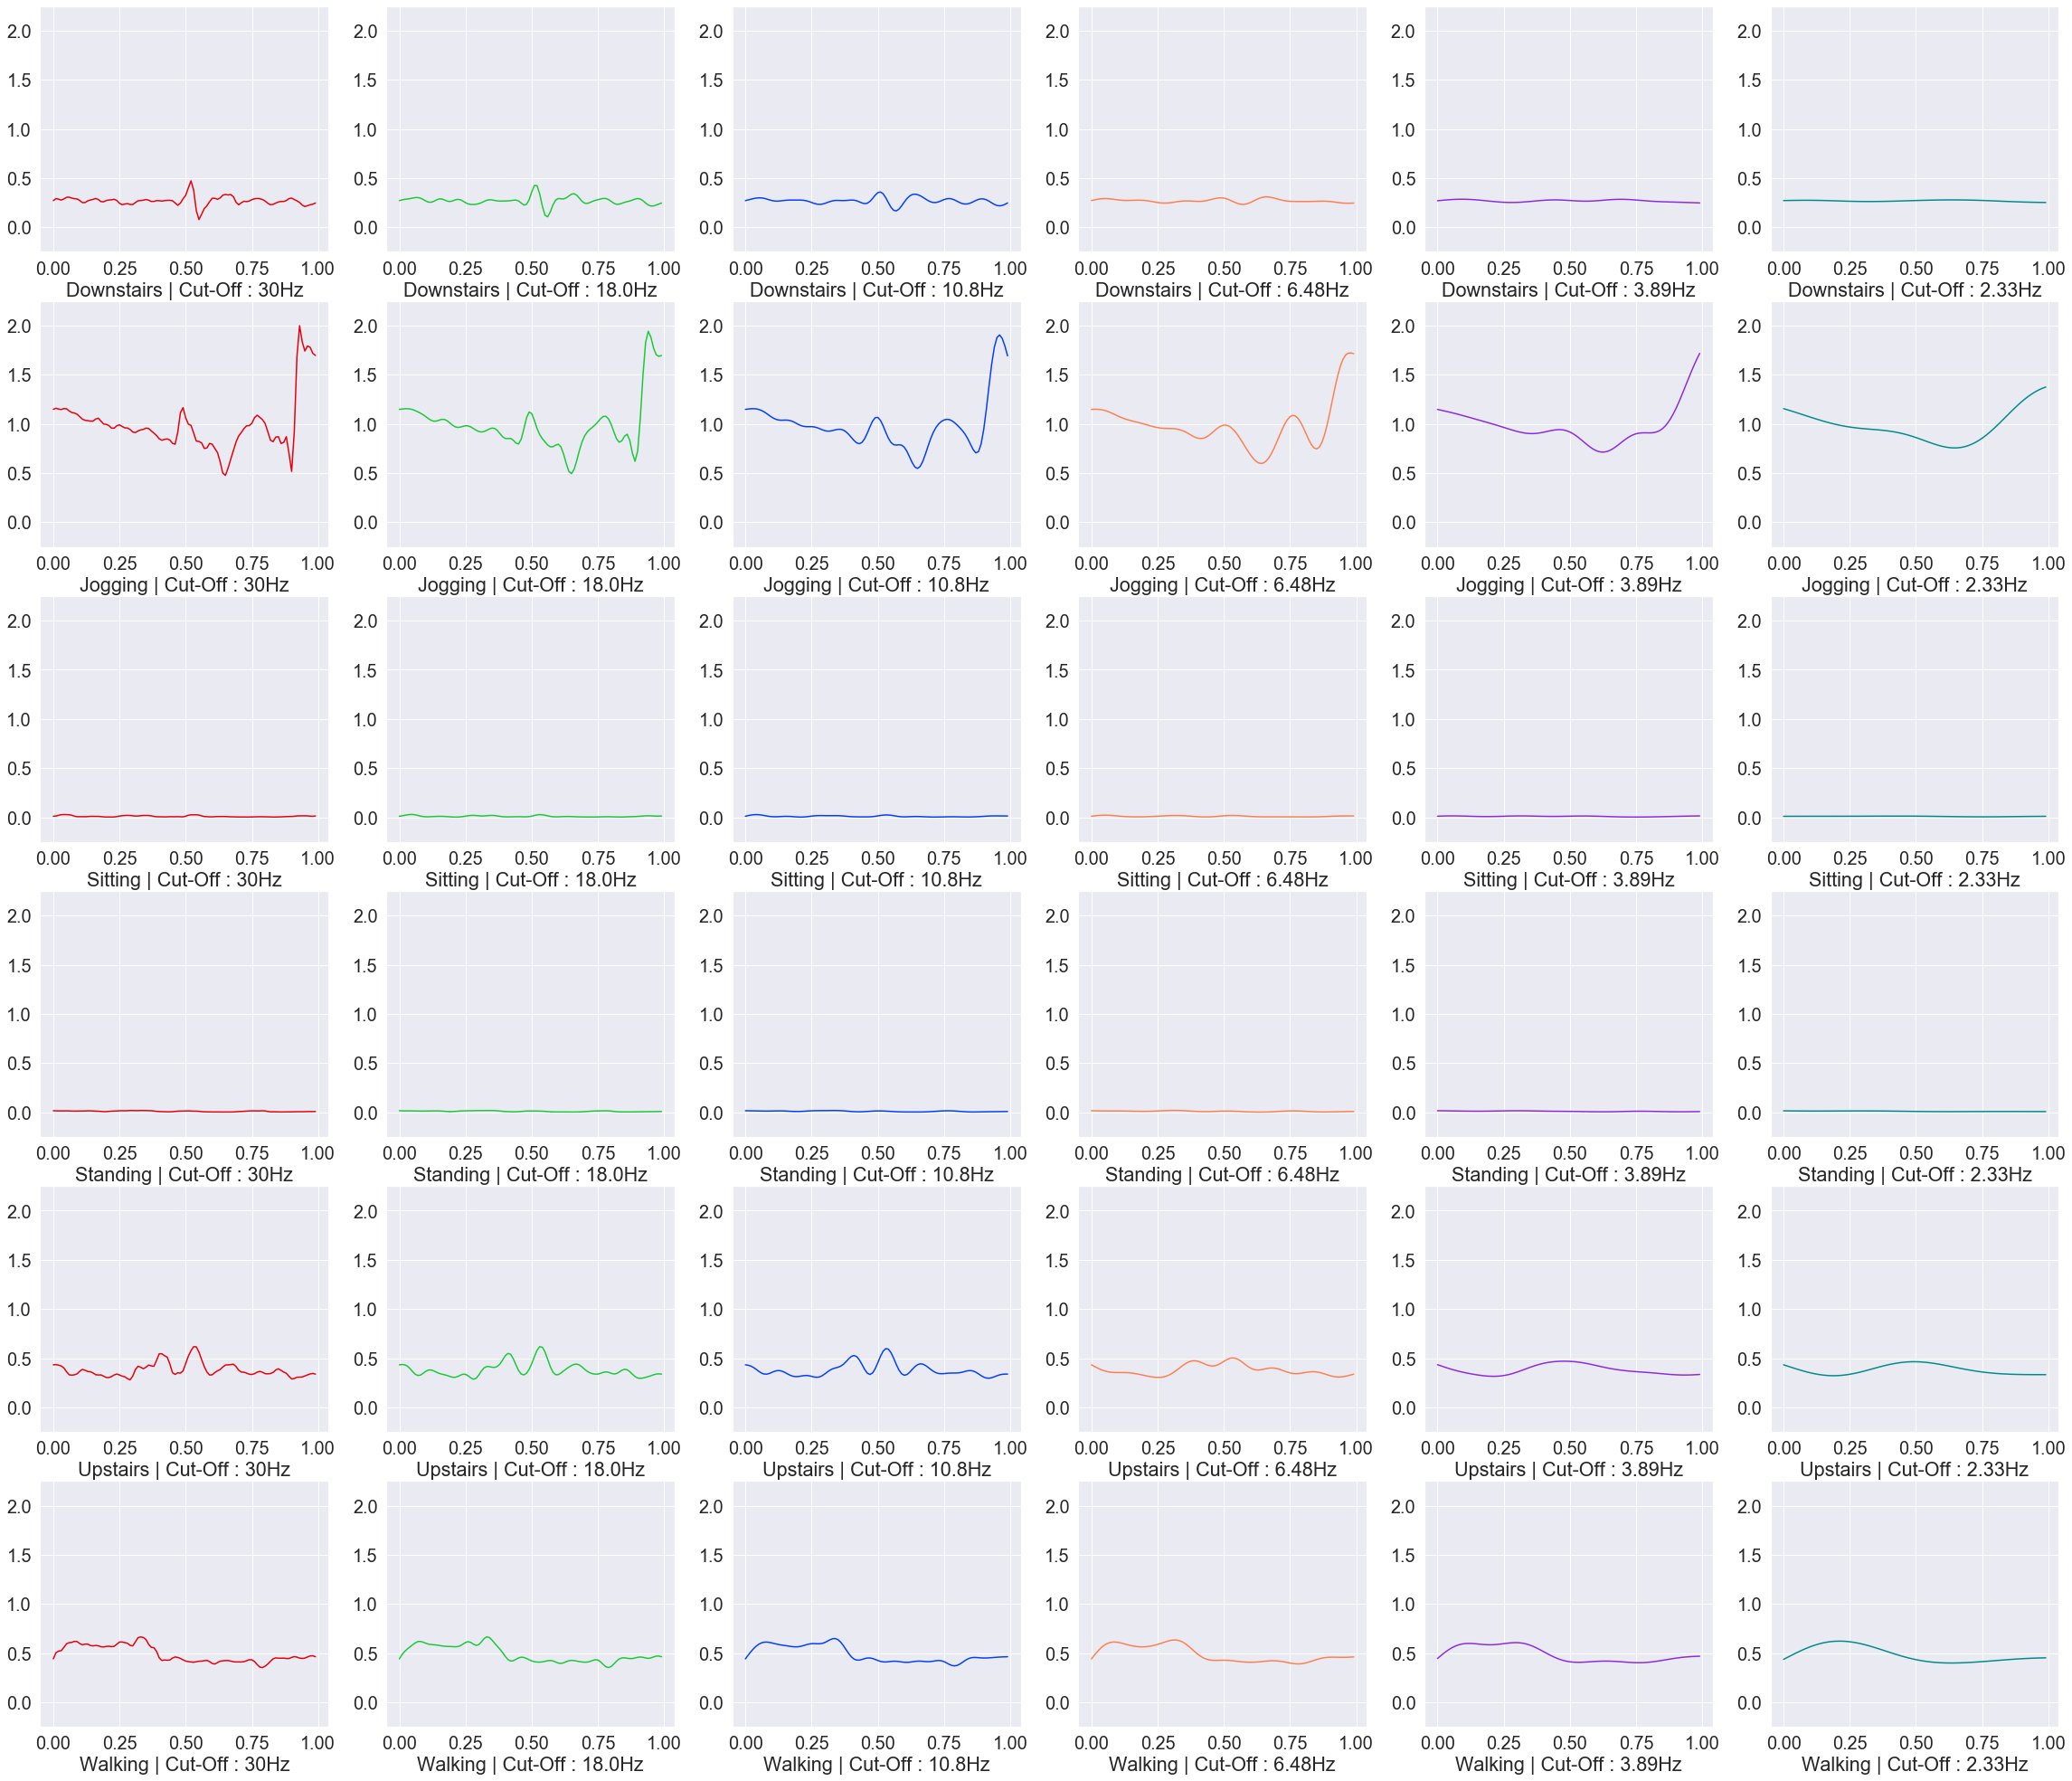

In [673]:
from scipy import signal
fs = 100  # Sampling frequency
t = np.arange(100) / fs
fc = 30
fig, ax = plt.subplots(nrows=6, ncols=6)
fig.set_size_inches(40,35)
for i in range(6):
    fc = 30
    for j in range(6):
        w = fc / (fs / 2) # Normalize the frequency
        b, a = signal.butter(5, w, 'low')
        output = signal.filtfilt(b, a, cf[cf['Activity']==i+1]['userAcceleration.y_std'])
        sns.lineplot(t, output,ax=ax[i][j], color=colour[j])
        ax[i][j].set(xlabel=codes[i+1]+' | Cut-Off : '+str(round(fc,2))+'Hz')
        ax[i][j].set_ylim(-0.25, 2.25)
        fc *= 0.6

<h1> Moving Average Filter Implementation on a Noisy Sine Wave </h1>

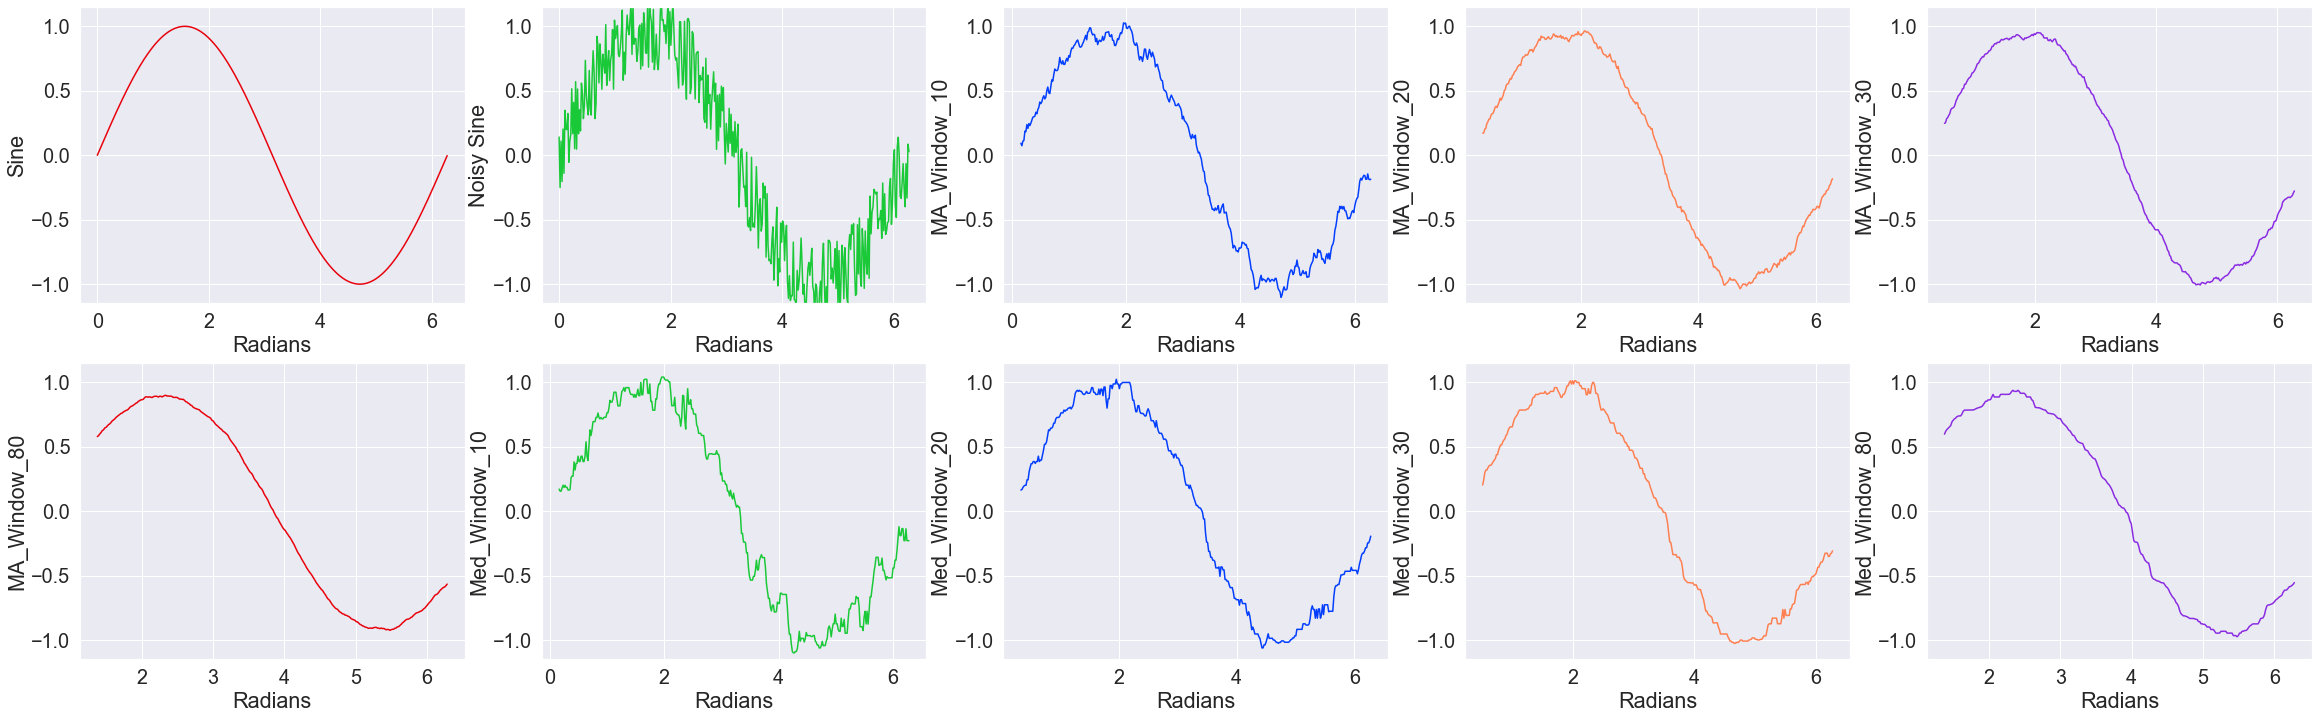

In [660]:
import random, math
test_signal = pd.DataFrame(np.array([i*3.14/180 for i in range(361)]))
test_signal.columns = ['Radians']
test_signal['Sine'] = np.sin(test_signal['Radians'])
test_signal['Noisy Sine'] = test_signal['Radians'].apply(lambda x: np.sin(x)+random.uniform(-1,1)/3)
test_signal['MA_Window_10'] = test_signal['Noisy Sine'].rolling(10).mean()
test_signal['MA_Window_20'] = test_signal['Noisy Sine'].rolling(20).mean()
test_signal['MA_Window_30'] = test_signal['Noisy Sine'].rolling(30).mean()
test_signal['MA_Window_80'] = test_signal['Noisy Sine'].rolling(80).mean()
test_signal['Med_Window_10'] = test_signal['Noisy Sine'].rolling(10).median()
test_signal['Med_Window_20'] = test_signal['Noisy Sine'].rolling(20).median()
test_signal['Med_Window_30'] = test_signal['Noisy Sine'].rolling(30).median()
test_signal['Med_Window_80'] = test_signal['Noisy Sine'].rolling(80).median()

sns.set(palette='bright', font_scale=1.8)
fig, ax = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(40,12)
colour = ['r','g','b','coral','blueviolet','darkcyan']
c2 = 0
for r in range(2):
    c= 0
    while True:
        sns.lineplot(x='Radians', y=test_signal.iloc[:, c2+1], data=test_signal, ax=ax[r][c], color=colour[c])
        ax[r][c].set(ylabel=test_signal.columns[c2+1], xlabel='Radians')
        ax[r][c].set_ylim(-1.15, 1.15)
        c += 1
        c2 += 1
        if c==5:
            break

<h1> ButterWorth Filter Implementation on Noisy Sine Wave </h1>

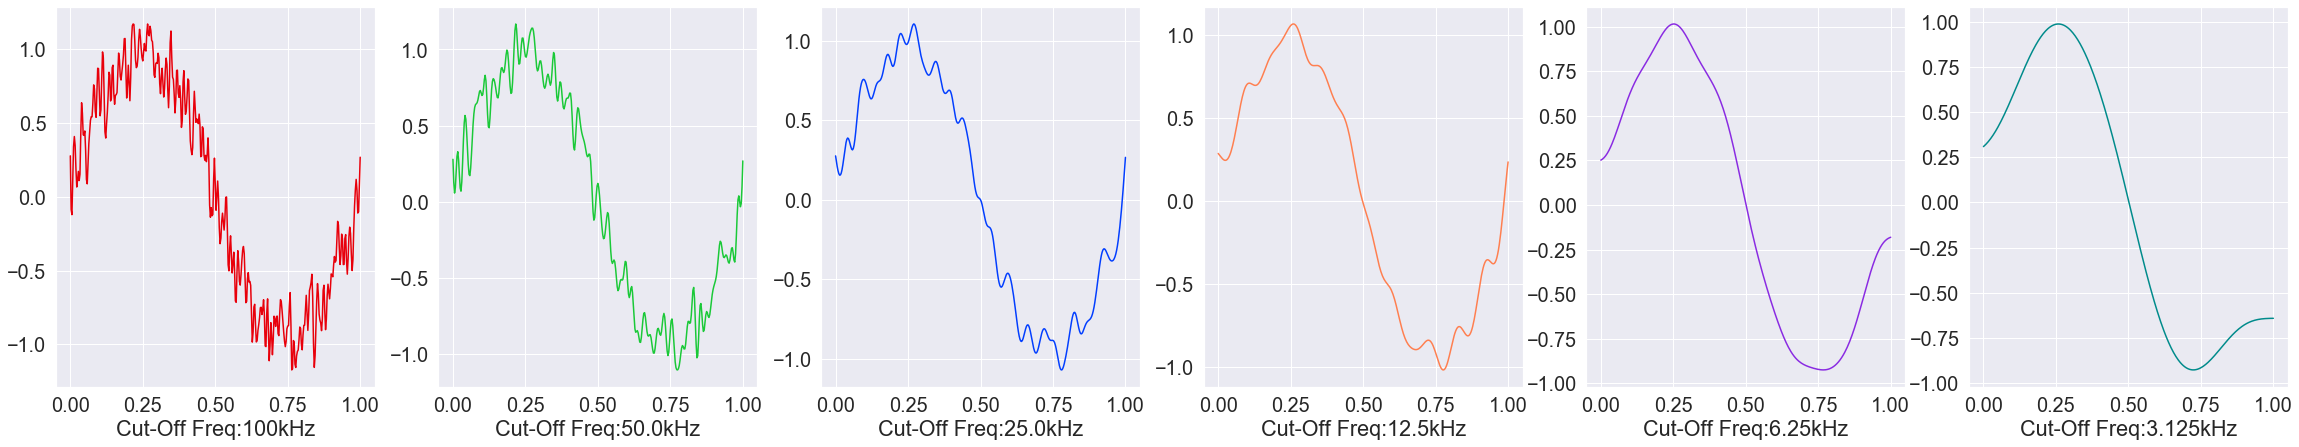

In [657]:
from scipy import signal
fs = 360  # Sampling frequency
fig, ax = plt.subplots(nrows=1, ncols=6)
fig.set_size_inches(40,7)
t = np.arange(361) / fs
fc = 100
for i in range(6):
    w = fc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(5, w, 'low')
    output = signal.filtfilt(b, a, test_signal['Noisy Sine'])
    sns.lineplot(t, output,ax=ax[i], color=colour[i])
    ax[i].set(xlabel='Cut-Off Freq:'+str(fc)+'kHz')
    fc = fc*0.5

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(35, 35)
corr = sns.heatmap(df.corr(), annot=True, fmt='.2f')
corr.set_aspect("equal")

In [677]:
def metrics(algo, test_y, test_X):
    np.set_printoptions(suppress=True, precision=3)
    pred, col = algo.predict(test_X), np.random.choice(['Blues'])#,'viridis','plasma','magma','cividis','PuBuGn','cool'])
    target = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
    dim = True if str(pred.shape).split(',')[1].strip()=='6)' else False
    pred_y = 1+np.argmax(pred, 1) if dim else pred
    cm, quack = c_m(test_y, pred_y), clfrep(test_y, pred_y, target_names = target)
    cm_sns = sns.heatmap(cm, annot=True, cmap=col, fmt='g',annot_kws={'size':16}, vmax=600, xticklabels=[i for i in Activity_Types.keys()], yticklabels=[i for i in Activity_Types.keys()])
    cm_sns.set_aspect("equal")
    print(quack)
    #print(cm)
    score = r2score(test_y, pred_y, multioutput='variance_weighted')
    print('ROC AUC: ', roc_auc(test_y,algo.predict_proba(test_X), multi_class='ovr'))
    print('R2 Score: {:1.3f}'.format(score))
    plt.figure()
    try:
        importance, tree_imp, val = {}, algo.feature_importances_, 0
        for i in train_cols:
            importance[i] =  tree_imp[train_cols.index(i)]
        imp = sorted(importance.items(), key=lambda item: item[1], reverse=True)
        plot = sns.barplot([i[0] for i in imp], [i[1] for i in imp])
        plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
    except AttributeError:
        print('Attribute Error. Passing as of now')

In [445]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
out = pca.fit_transform(df[cols])
out_ = np.concatenate((out, df['Activity'].values.reshape(-1,1)), 1)
plot = pd.DataFrame(out_)
plot.columns = ['ax1','ax2','act']

<h1> Decision Tree</h1>

#_________________Decision Tree________________________#
              precision    recall  f1-score   support

  Downstairs       0.86      0.89      0.87      1277
     Jogging       0.98      0.97      0.97      1310
     Sitting       1.00      1.00      1.00      3268
    Standing       1.00      1.00      1.00      2946
    Upstairs       0.88      0.87      0.88      1447
     Walking       0.95      0.95      0.95      3399

    accuracy                           0.96     13647
   macro avg       0.94      0.94      0.94     13647
weighted avg       0.96      0.96      0.96     13647

ROC AUC:  0.9872049646046775
R2 Score: 0.804


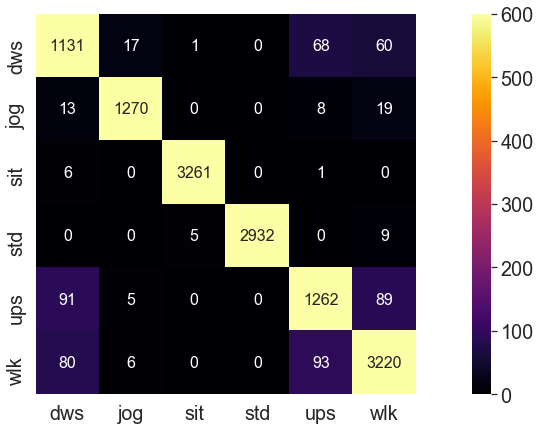

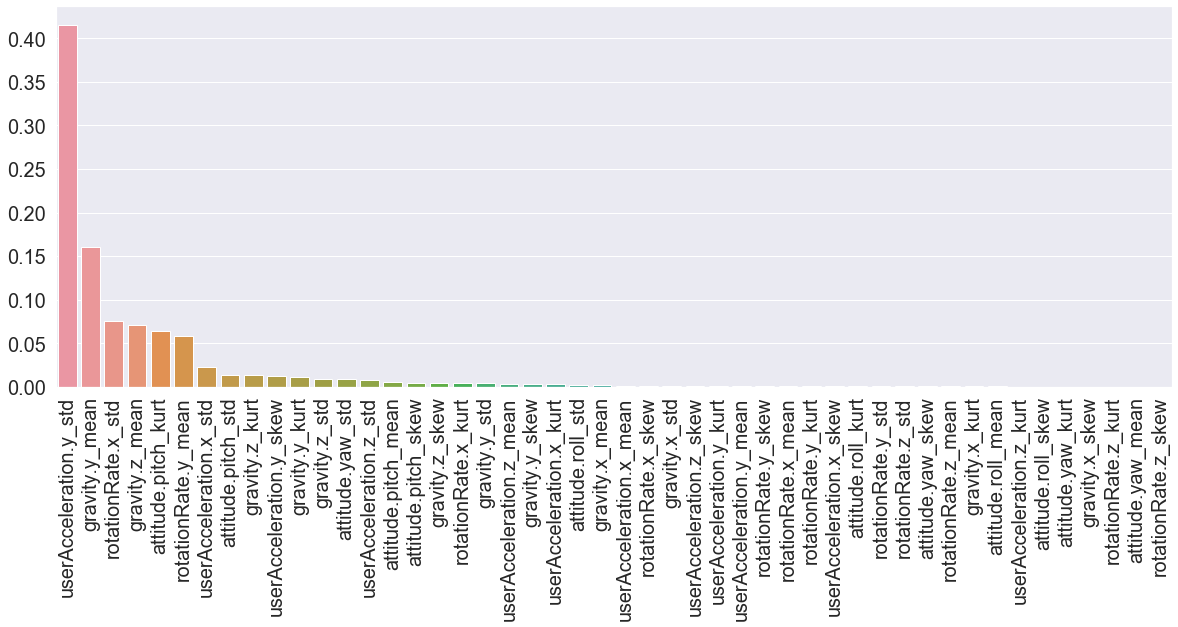

In [557]:
from sklearn.tree import DecisionTreeClassifier  as DT
from sklearn.model_selection import cross_val_score as cv
tree_x = DT(criterion='gini', max_depth=80, min_samples_leaf = 10, min_samples_split = 2, max_features = 9)
scores = cv(estimator=tree_x, X=train_X, y=train_y, cv=10, n_jobs=4)
labels = [i for i in Activity_Types.keys()]
tree_x.fit(train_X, train_y)
print('#_________________Decision Tree________________________#')
metrics(tree_x, test_y, test_X)
#print('# Feature Importance #' tree.feature_importance_)

In [83]:
#importance = {}
#tree_imp = tree_x.feature_importances_
#for i in cols:
#    importance[i] =  tree_imp[cols.index(i)]
#val = 0
#for key, value in sorted(importance.items(), key=lambda item: item[1], reverse=True):
#    print("{:25s}: {:1.3f} {:1.3f}" .format(key, value, val+value))
#    val += value

<h1> Random Forest </h1>

#_________________Random Forest________________________#
              precision    recall  f1-score   support

  Downstairs       0.94      0.94      0.94      1277
     Jogging       0.99      0.98      0.99      1310
     Sitting       1.00      1.00      1.00      3268
    Standing       1.00      1.00      1.00      2946
    Upstairs       0.95      0.96      0.95      1447
     Walking       0.98      0.99      0.99      3399

    accuracy                           0.98     13647
   macro avg       0.98      0.98      0.98     13647
weighted avg       0.98      0.98      0.98     13647

ROC AUC:  0.9993448098050858
R2 Score: 0.920


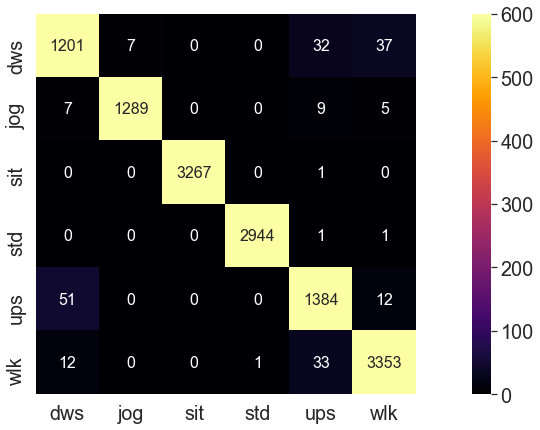

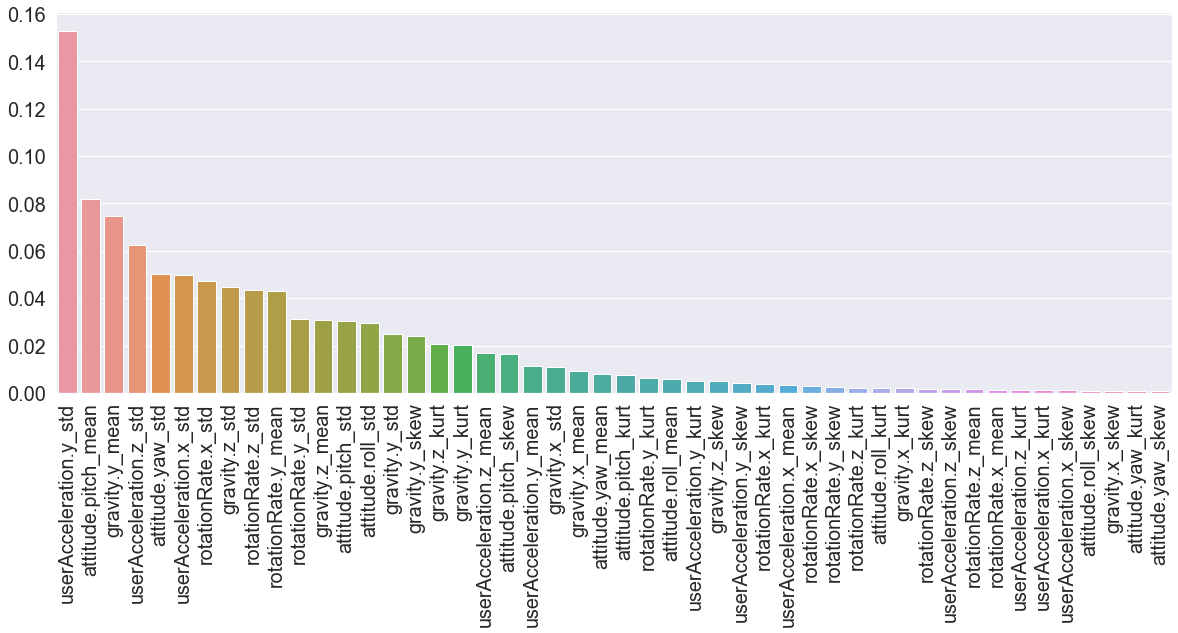

In [559]:
from sklearn.ensemble import RandomForestClassifier as RF
forest = RF(n_estimators = 100, criterion='gini', random_state = 62, max_depth = 100, min_samples_split = 50)
forest.fit(train_X,train_y)
print('#_________________Random Forest________________________#')
metrics(forest, test_y, test_X)

<h1> LightGBM </h1>

              precision    recall  f1-score   support

  Downstairs       0.97      0.97      0.97      1277
     Jogging       1.00      0.99      0.99      1310
     Sitting       1.00      1.00      1.00      3268
    Standing       1.00      1.00      1.00      2946
    Upstairs       0.97      0.98      0.98      1447
     Walking       0.99      0.99      0.99      3399

    accuracy                           0.99     13647
   macro avg       0.99      0.99      0.99     13647
weighted avg       0.99      0.99      0.99     13647

ROC AUC:  0.9998409898860471
R2 Score: 0.953


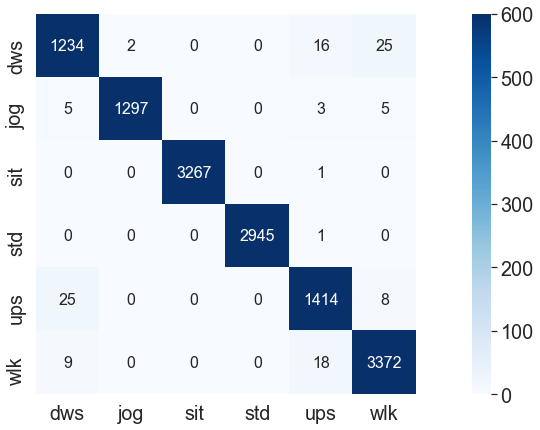

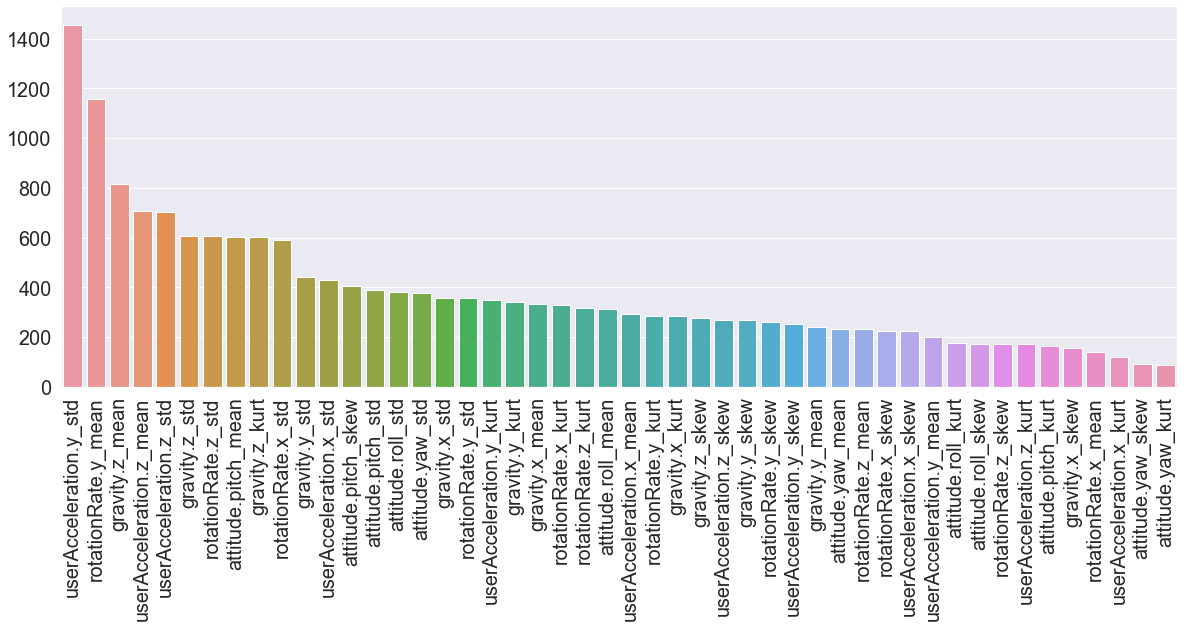

In [678]:
from lightgbm import LGBMClassifier as LGBM
lgb = LGBM(objective='multiclass', max_depth=12, silent=False)
lgb.fit(train_X, train_y)
metrics(lgb, test_y, test_X)

<h1> Artificial Neural Networks </h1> 

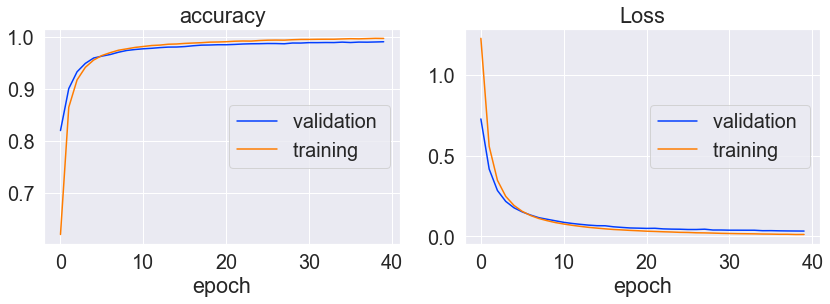

accuracy
	validation       	 (min:    0.218, max:    0.990, cur:    0.990)
	training         	 (min:    0.546, max:    0.997, cur:    0.997)
Loss
	validation       	 (min:    0.033, max: 17912.246, cur:    0.033)
	training         	 (min:    0.012, max:    3.244, cur:    0.012)
13647/13647 [==============================] - 0s 12us/step
#______Neural Network_____#
# NN Accuracy 99.033 %     #
# NN Loss 0.033            #


In [681]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.optimizers import adam, SGD
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from livelossplot import PlotLossesKeras


scaler = StandardScaler()
stop = EarlyStopping(patience=2, monitor='val_loss')
train_y_bin = pd.get_dummies(train_y)
test_y_bin = pd.get_dummies(test_y)
model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (train_X.shape[1], )))
#model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(6, activation = 'softmax'))
model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#hist = model.fit(X_new, Y_new, validation_split = 0.2, epochs = 300, verbose = 1, batch_size = 64, callbacks=[early_stopping_monitor])
train_scaled = pd.DataFrame(scaler.fit_transform(train_X.values))
test_scaled = pd.DataFrame(scaler.transform(test_X.values))
hist = model.fit(train_scaled, train_y_bin, validation_data = (test_scaled, test_y_bin), epochs = 40, verbose = 1, batch_size = 2048, callbacks=[stop, PlotLossesKeras()], shuffle=True)
score = model.evaluate(test_scaled, test_y_bin, batch_size = 64)
print('#______Neural Network_____#')
print('# NN Accuracy %.3f %%     #' %(score[1]*100))
print('# NN Loss %.3f            #' %(score[0]))

              precision    recall  f1-score   support

  Downstairs       0.98      0.95      0.97      1277
     Jogging       1.00      0.99      1.00      1310
     Sitting       1.00      1.00      1.00      3268
    Standing       1.00      1.00      1.00      2946
    Upstairs       0.97      0.97      0.97      1447
     Walking       0.99      0.99      0.99      3399

    accuracy                           0.99     13647
   macro avg       0.99      0.99      0.99     13647
weighted avg       0.99      0.99      0.99     13647

ROC AUC:  0.9996386976117946
R2 Score: 0.950
Attribute Error. Passing as of now


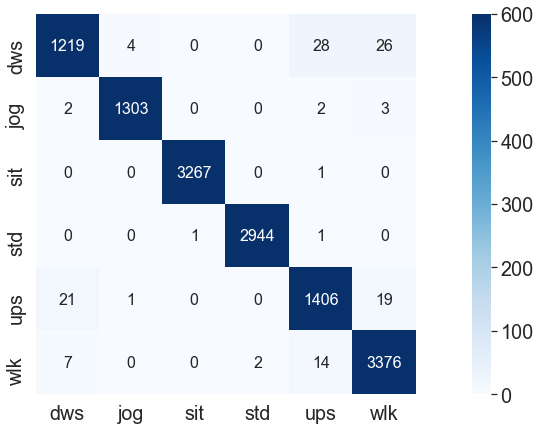

<Figure size 1440x504 with 0 Axes>

In [682]:
metrics(model, test_y, test_scaled)

<h1> XGBoost Classifier </h1>

In [679]:
from xgboost import XGBClassifier 
xgb = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.05,  
                      colsample_bytree = 0.2,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      n_estimators=140, 
                      reg_alpha = 0.2,
                      max_depth=12, 
                      gamma=10)
history = xgb.fit(train_X, train_y, eval_set = [(test_X, test_y)], eval_metric=["merror", "mlogloss"], verbose=False)
evals_result = xgb.evals_result()

              precision    recall  f1-score   support

  Downstairs       0.95      0.94      0.94      1277
     Jogging       0.99      0.99      0.99      1310
     Sitting       1.00      1.00      1.00      3268
    Standing       1.00      1.00      1.00      2946
    Upstairs       0.94      0.95      0.94      1447
     Walking       0.98      0.98      0.98      3399

    accuracy                           0.98     13647
   macro avg       0.98      0.98      0.98     13647
weighted avg       0.98      0.98      0.98     13647

ROC AUC:  0.9991138247843566
R2 Score: 0.919


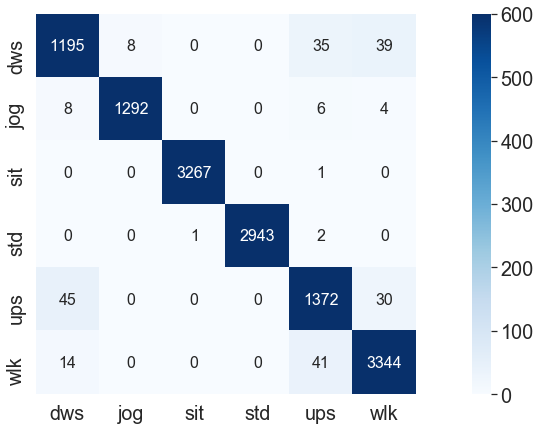

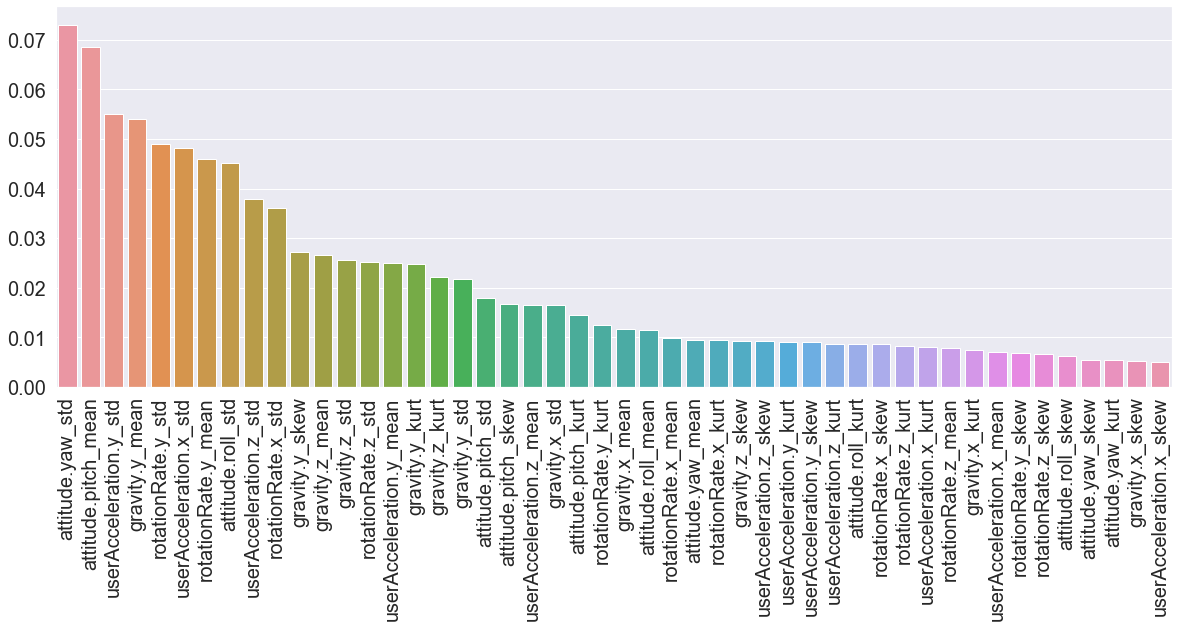

In [680]:
metrics(xgb, test_y, test_X)

In [668]:
merror = evals_result['validation_0']['merror']
mlogloss = evals_result['validation_0']['mlogloss']
x = np.linspace(0, len(merror), num=len(merror))

[Text(0, 0.5, 'LogLoss'), Text(0.5, 0, 'Estimator')]

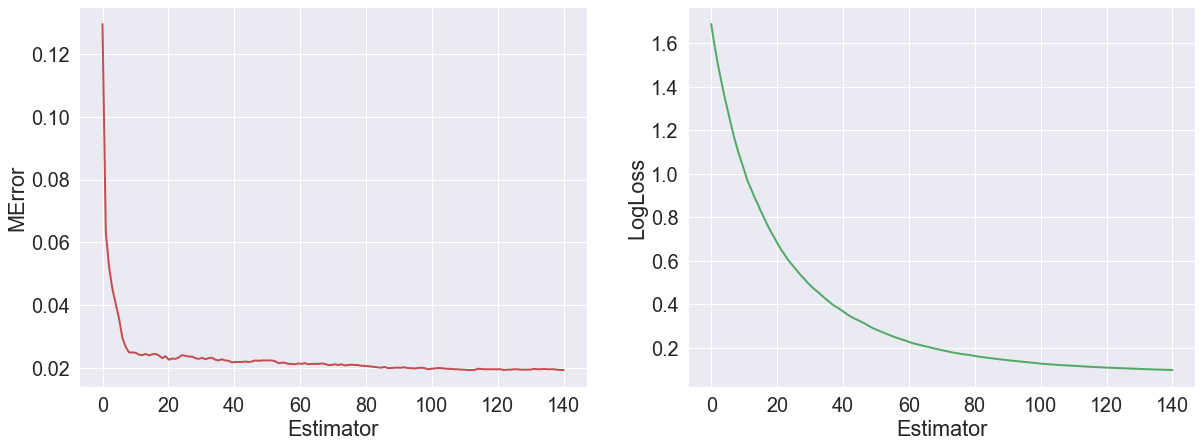

In [669]:
fig, ax = plt.subplots(nrows=1,ncols=2)
sns.set()
sns.lineplot(x, merror, ax=ax[0], palette='bright', linewidth=2, color='r')
sns.lineplot(x, mlogloss, ax=ax[1], palette='bright', linewidth=2, color='g')
ax[0].set(xlabel='Estimator', ylabel='MError')
ax[1].set(xlabel='Estimator', ylabel='LogLoss')

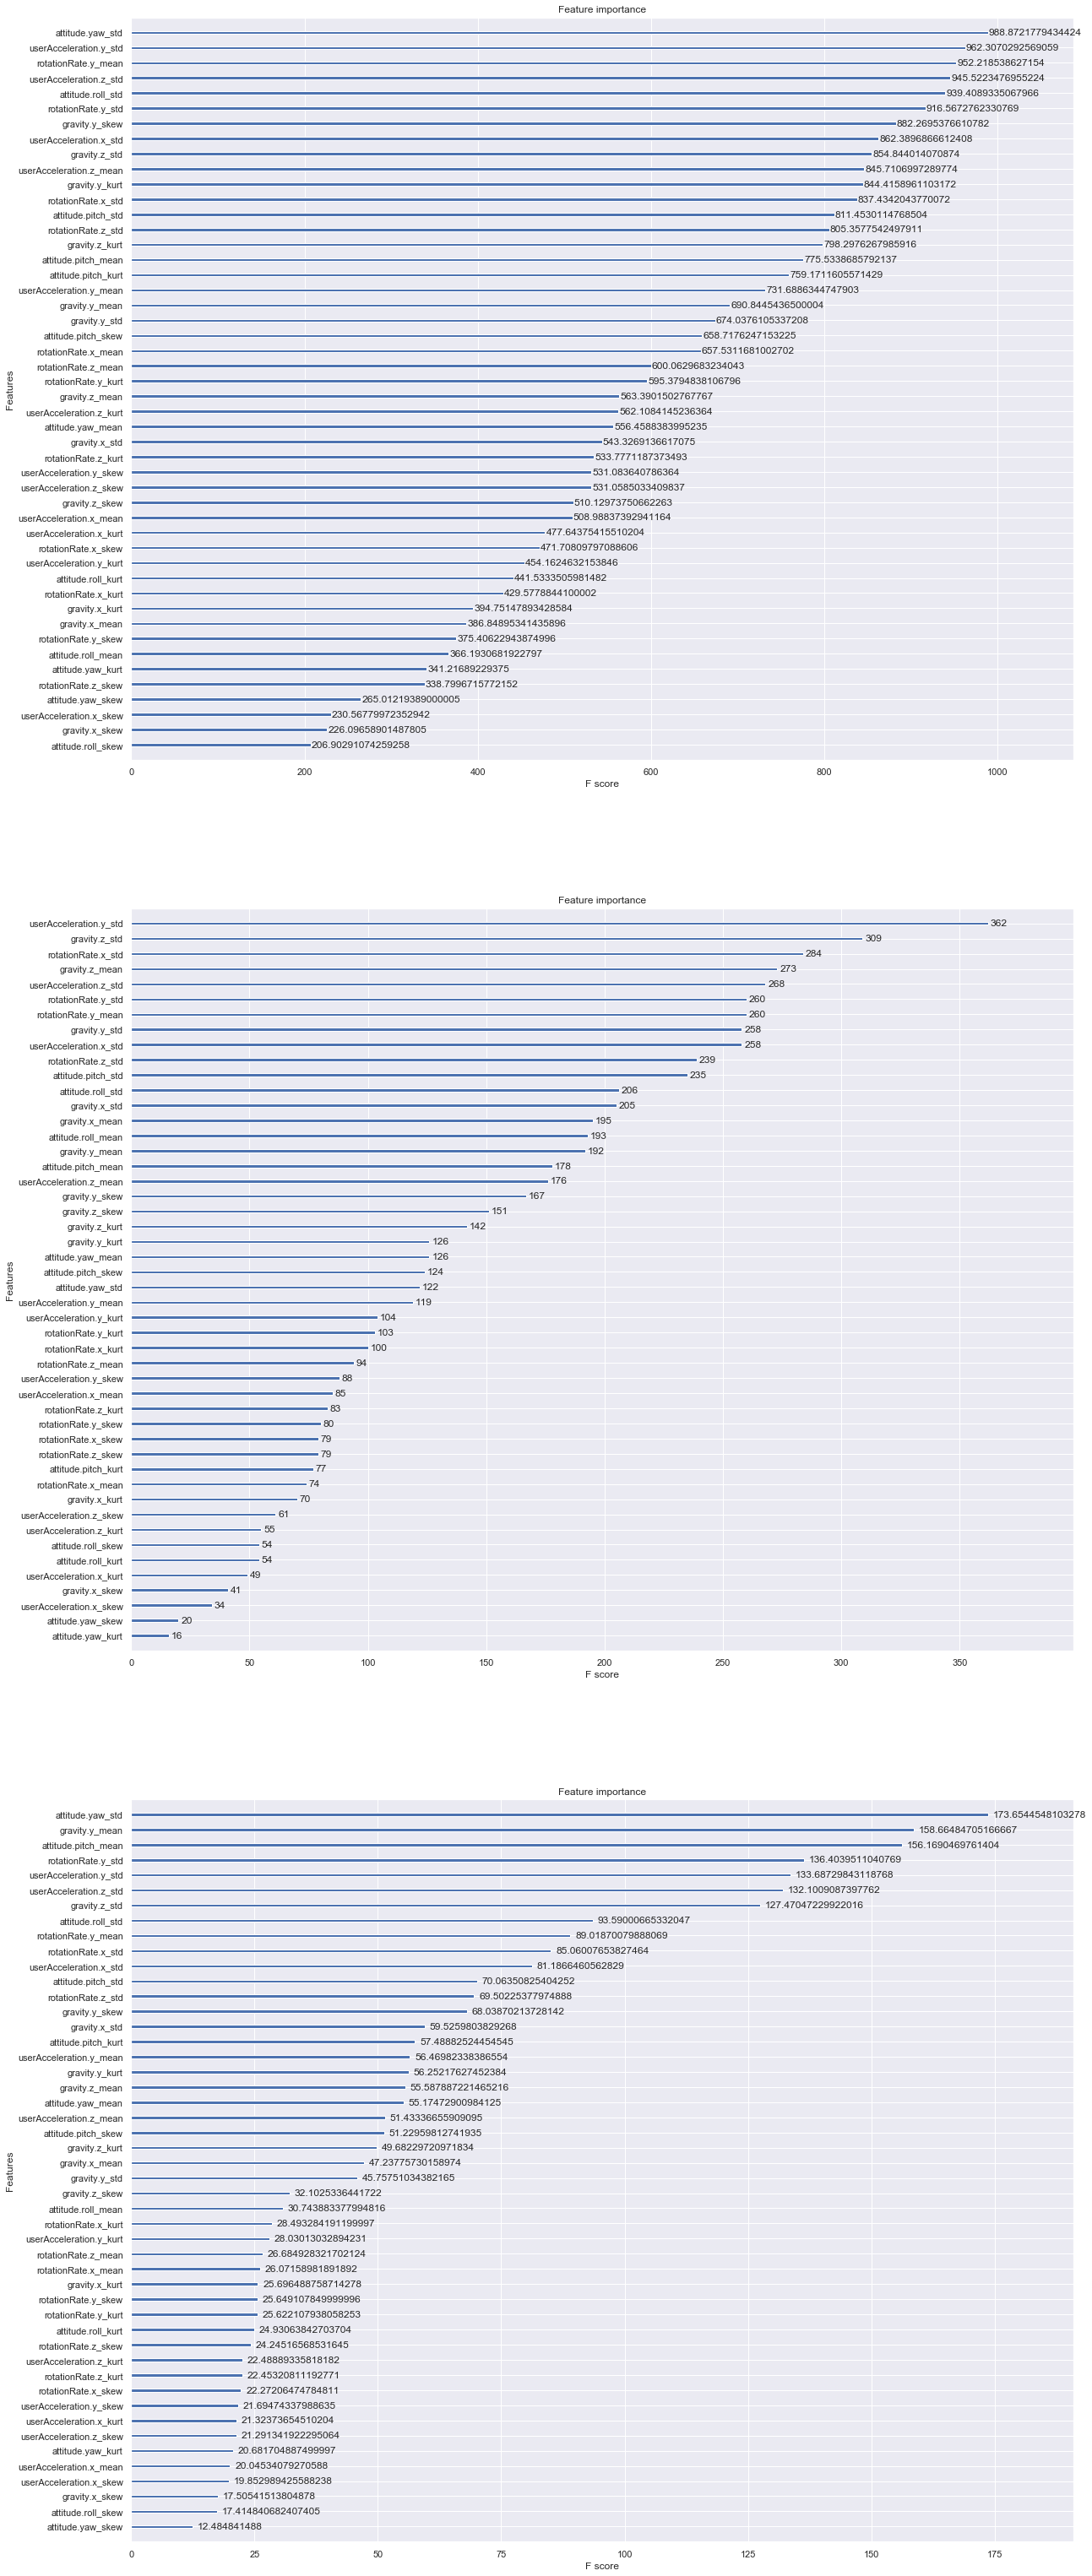

In [670]:
from xgboost import plot_tree, plot_importance
os.environ["PATH"] += os.pathsep + 'C:/Users/Shashi Suman/Desktop/AI Project/release/bin/'
fig, ax = plt.subplots(nrows=3,)
fig.set_size_inches(20, 55)
plot_importance(xgb,ax=ax[0], importance_type='cover')
plot_importance(xgb,ax=ax[1], importance_type='weight')
plot_importance(xgb,ax=ax[2], importance_type='gain')